In [1]:
:set -i./src
:load NotebookPrelude

The `NotebookPrelude` aimes to make it somewhat easy to:

- Construct and display charts.
- Define topologies, i.e. graphs with `BearerCharacteristic` edge weights.
- Display topologies via graphviz.
- Compute statistics on those topologies, starting with `all_pairs_time_to_send`.

This notebook aims to give the reader a basic idea of how to do these things.

To start, you can use `chart_numeric_xy` and a state-monad-lens style to set up charts. These are defined in a lens-with-state-monad style, because that seems to actually be nice in the context of an interactive notebook.

In [ ]:
chart_numeric_xy $ do
  layout_title .= "Hello chart!"
  layout_x_axis . laxis_title .= "Types"
  layout_y_axis . laxis_title .= "Productivity"
  showPlot' $ do
    plot_lines_title .= "a line"
    plot_lines_style .= mk (line_color .= opaque green)
    plot_lines_values .= [[(0,0),(1,1)],[(0,0.4),(1,0.8)]]
  showPlot' $ do
    plot_points_title .= "some points"
    plot_points_style .= mk (do
      point_color .= opaque red
      point_radius .= 2.0)
    plot_points_values .= [(0.2,0.4), (0.8, 0.9)]

Topologies can be manually constructed using the `Algebra.Graph.Labelled.AdjacencyMap` module, along with `DeltaQ.Topography.edge :: e -> Last e` for edges (edge labels must be a `Semigroup`, in order to deal with multiple edges in an overlay).

`Algebra.Graph.Labelled.AdjacencyMap.Builder` is an attempt to make it easy to construct possibly random graphs within a notebook. The following cell demonstrates its main features, along with basic graph visualization.

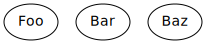

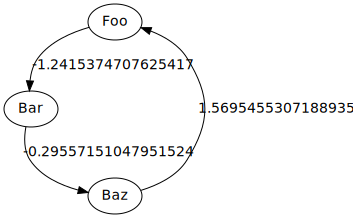

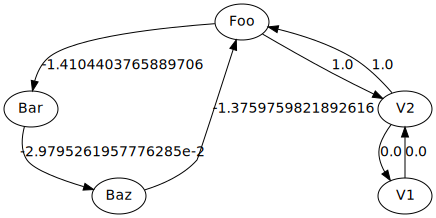

In [19]:
-- A graph on 3 vertices with no edges.
-- The 4th parameter is the edge labels, and it should be free but this notebook has a hard time with
-- that and sets it to Any, causing trouble later on.
let emptyGraph :: Builder s r f Double String (Vertex r, Vertex r, Vertex r)
    emptyGraph = do
      v1 <- freshVertex
      v2 <- freshVertex
      v3 <- freshVertex
      setLabel v1 "Foo"
      setLabel v2 "Bar"
      setLabel v3 "Baz"
      pure (v1, v2, v3)
      
-- The simplest way to build the graph is via IO, which can source some PRNG entropy.
((itt,labels),_) <- buildIO emptyGraph

-- A graph can be drawn with graphviz by specifying a layout and some attributes
let layout :: LayoutMethod Int
    layout = LayoutDot
    nodeAttrs :: (VertexRep -> Maybe String) -> VizNode n VertexRep
    nodeAttrs labels = strlabel (fromMaybe "" . labels . snd)
    edgeAttrs :: VizEdge n (Last Double)
    edgeAttrs = strlabel (\(_, _, el) -> show (getLast el))

showTopology (viz Directed layout (nodeAttrs labels) edgeAttrs) itt

-- A directed graph that is a triangle on the emptyGraph vertices.
-- Edge labels are randomly-generated in a normal distribution.
let triangle :: Builder s r f Double String (Vertex r)
    triangle = directed $ do
      (v1, v2, v3) <- emptyGraph
      (e1, e2, e3) <- random ((,,) <$> normal 0 1 <*> normal 0 1 <*> normal 0 1)
      directedEdge e1 v1 v2
      directedEdge e2 v2 v3
      directedEdge e3 v3 v1
      pure v1

((itt,labels),_) <- buildIO triangle
showTopology (viz Directed layout (nodeAttrs labels) edgeAttrs) itt

-- Graphs can also be undirected, and the two can even be mixed.
-- Under-the-hood, undirected edges are two directed edges, so be aware of this when
-- looking at its graphviz drawing.
let mixed :: Builder s r f Double String ()
    mixed = do
      tip <- triangle
      v1 <- freshVertex
      v2 <- freshVertex
      setLabel v1 "V1"
      setLabel v2 "V2"
      undirected $ do
        undirectedEdge 0.0 v1 v2
        undirectedEdge 1.0 v2 tip
      
((itt,labels),_) <- buildIO mixed
showTopology (viz Directed layout (nodeAttrs labels) edgeAttrs) itt

With a simple DeltaQ model, we can weight the graphs with G/S and some link-layer parameters, then compute shortest-paths, giving a fairly decent simulation of a network. Here it is:

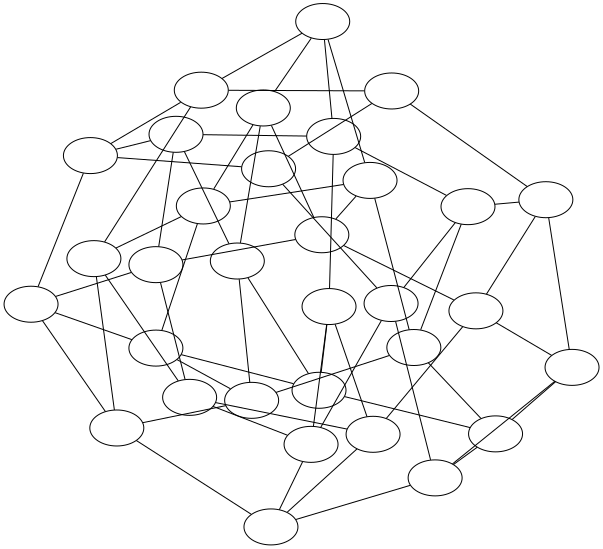

In [31]:
randomEdgeWeight :: Random BearerCharacteristics
randomEdgeWeight = do
  g <- normal 700000.0 100000.0
  s <- normal 40000.0  25000.0
  pure $ ethernet_bearer (picosecondsToDiffTime (max 0 (round g))) (picosecondsToDiffTime (max 0 (round s)))

-- Example networks: for a given number of nodes, make two hamiltonian cycles
-- in random orders, using random edge weights as defined above.
-- The graph is made undirected by mirroring every edge.
exampleNetwork :: Natural -> Builder s r f BearerCharacteristics String ()
exampleNetwork n = undirected $ mirror $ do
  nodes <- freshVertices n
  cycle1 <- random $ shuffle nodes
  cycle2 <- random $ shuffle nodes
  cycleOn cycle1 randomEdgeWeight
  cycleOn cycle2 randomEdgeWeight

((itt,labels),_) <- buildIO (exampleNetwork 32)
layout = LayoutFdp False 0.1 1000 Nothing
showTopology (viz Undirected layout (nodeAttrs labels) mempty) itt

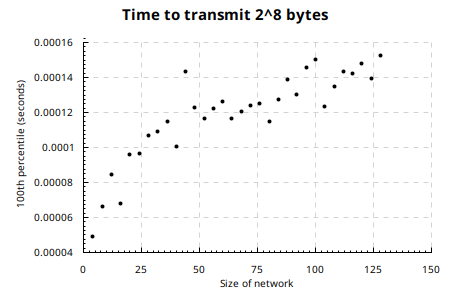

In [36]:
samplesFor :: [Natural] -> IO  [(Double, Double)]
samplesFor ns = forM ns $ \n -> do
  ((itt,_),_) <- buildIO (exampleNetwork n)
  let times = all_pairs_time_to_send (2 ^ 8) itt
      !datum = percentile 100 (flatten_data (arr id) times)
  pure (fromIntegral n, datum)

samples <- samplesFor [4,8..128]

chart_numeric_xy $ do
  layout_title .= "Time to transmit 2^8 bytes"
  layout_x_axis . laxis_title .= "Size of network"
  layout_y_axis . laxis_title .= "100th percentile (seconds)"
  showPlot' $ do
    plot_points_style .= mk (point_radius .= 2.0)
    plot_points_values .= samples